## Part 1: Modeling

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json
from time import time
from sklearn.metrics import r2_score, root_mean_squared_error

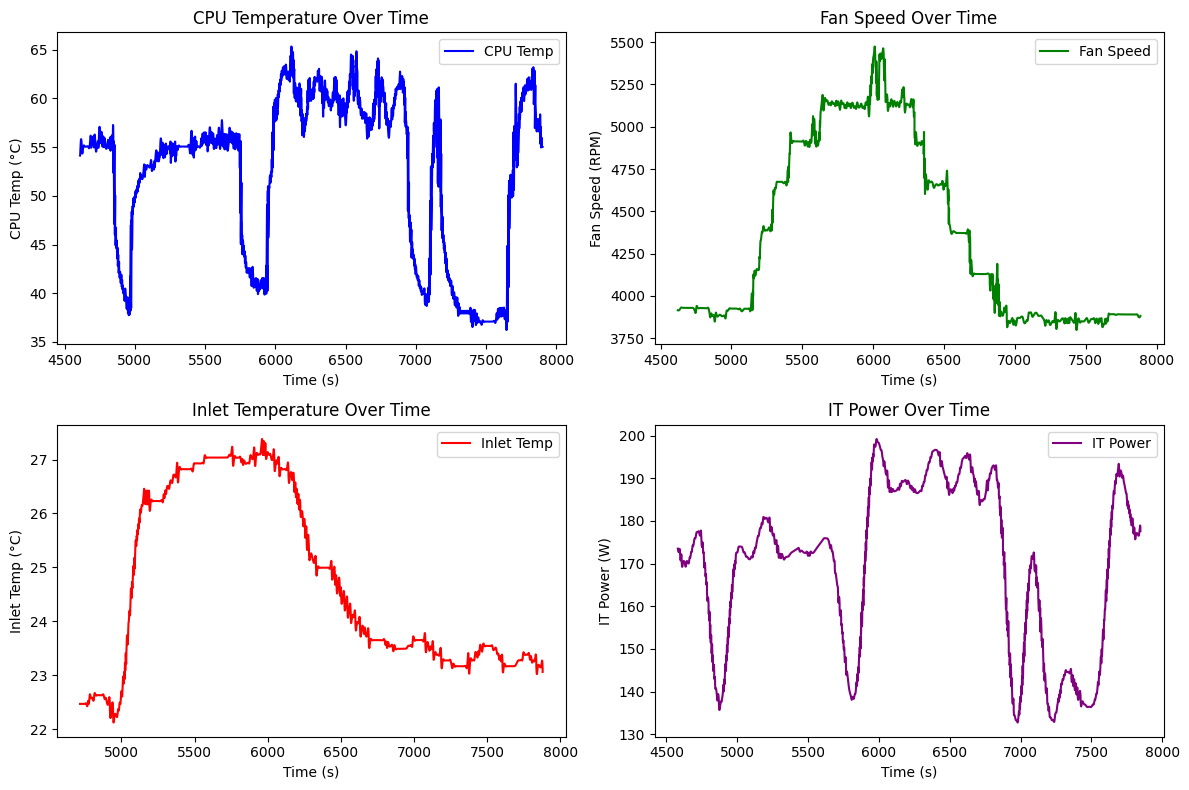

Shape of Final Dataframe = (4255, 5)


In [2]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

def plot_time_series_subplots(cpu_temp_df, fan_speed_df, inlet_temp_df, it_power_df, time_col):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # First subplot - CPU Temperature
    axs[0, 0].plot(cpu_temp_df[time_col], cpu_temp_df['cpu_temp'], color='blue', label='CPU Temp')
    axs[0, 0].set_title('CPU Temperature Over Time')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('CPU Temp (°C)')
    axs[0, 0].legend()

    # Second subplot - Fan Speed
    axs[0, 1].plot(fan_speed_df[time_col], fan_speed_df['fan_speed'], color='green', label='Fan Speed')
    axs[0, 1].set_title('Fan Speed Over Time')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Fan Speed (RPM)')
    axs[0, 1].legend()

    # Third subplot - Inlet Temperature
    axs[1, 0].plot(inlet_temp_df[time_col], inlet_temp_df['inlet_temp'], color='red', label='Inlet Temp')
    axs[1, 0].set_title('Inlet Temperature Over Time')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Inlet Temp (°C)')
    axs[1, 0].legend()

    # Fourth subplot - IT Power
    axs[1, 1].plot(it_power_df[time_col], it_power_df['it_power'], color='purple', label='IT Power')
    axs[1, 1].set_title('IT Power Over Time')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('IT Power (W)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


plot_time_series_subplots(cpu_temp_new, fan_speed_new, inlet_temp_new, it_power_new, time_col="time")

max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

# combined_df["cpu_temp_change"] = combined_df["cpu_temp"].diff().fillna(0)
# combined_df["it_power_change"] = combined_df["it_power"].diff().fillna(0)
# combined_df["fan_speed_change"] = combined_df["fan_speed"].diff().fillna(0)
# combined_df["cpu_temp_ma3"] = combined_df["cpu_temp"].rolling(window=3).mean().fillna(combined_df["cpu_temp"])
# combined_df["cpu_temp_std3"] = combined_df["cpu_temp"].rolling(window=3).std().fillna(0)

# print(combined_df.head())

df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    # 'cpu_temp_change': MinMaxScaler(),
    # 'it_power_change': MinMaxScaler(),
    # 'fan_speed_change': MinMaxScaler(),
    # 'cpu_temp_ma3': MinMaxScaler(),
    # 'cpu_temp_std3': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

min_fan_speed = 0
max_fan_speed = 8000
scale_beta = 5

df_scaled['fan_speed'] = scale_beta * (df['fan_speed'] - min_fan_speed) / (max_fan_speed - min_fan_speed)

# print(df_scaled.head())

def prepare_data(scaled_df, seq_length=8, k_step=24):

    # Define the input and output features
    # features_cols = ['cpu_temp', 'inlet_temp', 'it_power', 'cpu_temp_change', 'it_power_change', 'fan_speed_change', 'cpu_temp_ma3', 'cpu_temp_std3']
    features_cols = ['cpu_temp', 'inlet_temp', 'it_power', 'fan_speed']
    exogenous_col = 'fan_speed'
    output_col = 'cpu_temp'

    # Create sequences
    features = []
    exogenous = []
    outputs = []
    for i in range(len(scaled_df) - seq_length - k_step + 1):
        features.append(scaled_df[features_cols].iloc[i:i + seq_length].values)
        exogenous.append(scaled_df[exogenous_col].iloc[i + seq_length:i + seq_length + k_step].values)
        outputs.append(scaled_df[output_col].iloc[i + seq_length:i + seq_length + k_step].values)

    features = np.array(features)
    exogenous = np.array(exogenous).reshape(-1, k_step, 1)
    outputs = np.array(outputs).reshape(-1, k_step, 1)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    exogenous = torch.tensor(exogenous, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    # Split into train and test
    split_ratio = 0.8
    split_index = int(len(features) * split_ratio)
    train_features, test_features = features[:split_index], features[split_index:]
    train_exogenous, test_exogenous = exogenous[:split_index], exogenous[split_index:]
    train_outputs, test_outputs = outputs[:split_index], outputs[split_index:]

    train_dataset = TensorDataset(train_features, train_exogenous, train_outputs)
    test_dataset = TensorDataset(test_features, test_exogenous, test_outputs)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, outputs, split_index

In [3]:
torch.manual_seed(42)
np.random.seed(42)

class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step, fan_speed_impact_dim=32, fan_speed_impact=2.0):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size
        self.fan_speed_impact = fan_speed_impact

        # LSTM and Attention
        self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # Fan speed impact through an MLP (No ReLU to allow negative values)
        self.fan_speed_mlp = nn.Sequential(
            nn.Linear(k_step, fan_speed_impact_dim),  
            nn.Tanh(),  
            nn.Linear(fan_speed_impact_dim, lstm_hidden_size)  
        )

        # Fully connected layers
        self.dense1 = nn.Linear(lstm_hidden_size * 2, dense_hidden_size)  
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, k_step)

    def forward(self, x, exogenous_input_fan_speed):
        batch_size, seq_len, feature_dim = x.shape

        # print(f"x.shape = {x.shape}")
        # print(f"exogenous_input_fan_speed.shape = {exogenous_input_fan_speed.shape}")

        # LSTM Processing
        h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        attn_output, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out)
        lstm_features = attn_output[:, -1, :]  # Shape: (batch_size, lstm_hidden_size)

        # Process fan speed as an array of shape (batch_size, k_step)
        fan_speed_transformed = self.fan_speed_impact / (exogenous_input_fan_speed.squeeze(-1) + 1e-6)  # Avoid division by zero
        fan_speed_effect = self.fan_speed_mlp(fan_speed_transformed.squeeze(-1))  # Shape: (batch_size, lstm_hidden_size)
 
        # Concatenate features
        combined_features = torch.cat((lstm_features, fan_speed_effect), dim=1)  

        # Fully Connected Layers
        dense1_out = self.relu(self.dense1(combined_features))
        outputs = self.dense2(dense1_out)

        return outputs

def train_model(model, train_loader, test_loader, k_step, learning_rate=0.001, num_epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

    history = {'train_loss': [], 'test_loss': []}

    # Function to compute loss
    def evaluate_loss(loader, model):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_features, batch_exogenous, batch_outputs in loader:
                batch_exogenous = batch_exogenous.unsqueeze(-1)  # Ensure correct shape for fan speed
                outputs = model(batch_features, batch_exogenous)
                loss = criterion(outputs, batch_outputs.squeeze(-1))  # Fix dimension mismatch
                total_loss += loss.item()
        return total_loss / len(loader)

    train_loss = evaluate_loss(train_loader, model)
    test_loss = evaluate_loss(test_loader, model)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    print(f"Before Training: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    # wandb.log({"epoch": 0, "train_loss": train_loss, "test_loss": test_loss})

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, batch_exogenous, batch_outputs in train_loader:
            batch_exogenous = batch_exogenous.unsqueeze(-1)  # Ensure correct shape for fan speed
            
            optimizer.zero_grad()
            outputs = model(batch_features, batch_exogenous)
            loss = criterion(outputs, batch_outputs.squeeze(-1))  # Fix dimension mismatch
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Evaluate test loss
        test_loss = evaluate_loss(test_loader, model)
        history['test_loss'].append(test_loss)

        # Adjust learning rate
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        # wandb.log({"epoch": epoch+1, "train_loss": train_loss, "test_loss": test_loss})

    return model, history


def evaluate_model_original(model, data_loader, scaler, k_step):
    model.eval()
    all_actuals = []
    all_predictions = []

    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in data_loader:
            batch_exogenous = batch_exogenous.unsqueeze(-1)  # Ensure correct shape for fan speed
            
            outputs = model(batch_features, batch_exogenous)
            actual_values = batch_outputs.squeeze(-1)  # Shape: (batch_size, k_step)
            
            # Apply inverse transform
            outputs_original = scaler.inverse_transform(outputs.cpu().numpy())
            actual_original = scaler.inverse_transform(actual_values.cpu().numpy())

            # Store predictions and actuals
            all_actuals.append(actual_original)
            all_predictions.append(outputs_original)

    # Convert lists to arrays
    all_actuals = np.concatenate(all_actuals, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    # Compute overall RMSE
    avg_rmse = root_mean_squared_error(all_actuals, all_predictions)

    # Compute overall R²
    avg_r2 = r2_score(all_actuals.flatten(), all_predictions.flatten())
    
    print(f"Average R² Score: {avg_r2:.4f}")
    print(f"Average RMSE: {avg_rmse:.4f}")
    
    return avg_r2, avg_rmse


In [4]:
seq_length = 30
k_step = 30
input_size = 4 # cpu_temp, inlet_temp, it_power
lstm_hidden_size = 64
dense_hidden_size = 64
learning_rate = 0.001
num_epochs = 25

train_loader, test_loader, outputs, split_index = prepare_data(df_scaled, seq_length, k_step)
model = DualInputAttentionLSTM(input_size, lstm_hidden_size, dense_hidden_size, k_step, fan_speed_impact=-1)
trained_model, history = train_model(model, train_loader, test_loader, k_step, learning_rate, num_epochs)

Before Training: Train Loss: 0.4379, Test Loss: 0.1973
Epoch 1/25, Train Loss: 0.0794, Test Loss: 0.0090
Epoch 2/25, Train Loss: 0.0048, Test Loss: 0.0086
Epoch 3/25, Train Loss: 0.0043, Test Loss: 0.0099
Epoch 4/25, Train Loss: 0.0044, Test Loss: 0.0105
Epoch 5/25, Train Loss: 0.0041, Test Loss: 0.0094
Epoch 6/25, Train Loss: 0.0039, Test Loss: 0.0083
Epoch 7/25, Train Loss: 0.0039, Test Loss: 0.0088
Epoch 8/25, Train Loss: 0.0038, Test Loss: 0.0080
Epoch 9/25, Train Loss: 0.0037, Test Loss: 0.0073
Epoch 10/25, Train Loss: 0.0039, Test Loss: 0.0071
Epoch 11/25, Train Loss: 0.0035, Test Loss: 0.0074
Epoch 12/25, Train Loss: 0.0035, Test Loss: 0.0070
Epoch 13/25, Train Loss: 0.0034, Test Loss: 0.0061
Epoch 14/25, Train Loss: 0.0034, Test Loss: 0.0053
Epoch 15/25, Train Loss: 0.0032, Test Loss: 0.0051
Epoch 16/25, Train Loss: 0.0032, Test Loss: 0.0053
Epoch 17/25, Train Loss: 0.0031, Test Loss: 0.0047
Epoch 18/25, Train Loss: 0.0031, Test Loss: 0.0048
Epoch 19/25, Train Loss: 0.0031, Tes

In [5]:
r2, rmse = evaluate_model_original(trained_model, test_loader, scalers["cpu_temp"], k_step)

Average R² Score: 0.9511
Average RMSE: 1.9410


In [6]:
# # plot the r2 and rmse for different values of k step

# r2_values = []
# rmse_values = []

# for k_step in range(5, 61, 5):
#     train_loader, test_loader, outputs, split_index = prepare_data(df_scaled, seq_length, k_step)
#     model = DualInputAttentionLSTM(input_size, lstm_hidden_size, dense_hidden_size, k_step, fan_speed_impact=-1)
#     trained_model, history = train_model(model, train_loader, test_loader, k_step, learning_rate, num_epochs)

#     r2, rmse = evaluate_model_original(trained_model, test_loader, scalers["cpu_temp"], k_step)

#     print(f"k_step: {k_step}, R²: {r2:.4f}, RMSE: {rmse:.4f}")
#     r2_values.append(r2)
#     rmse_values.append(rmse)

In [7]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(range(5, 61, 5), r2_values, marker='o')
# plt.title('R² Score vs. k_step')
# plt.xlabel('k_step')
# plt.ylabel('R² Score')
# # plt.grid(True)
# plt.subplot(1, 2, 2)
# plt.plot(range(5, 61, 5), rmse_values, marker='o')
# plt.title('RMSE vs. k_step')
# plt.xlabel('k_step')
# plt.ylabel('RMSE')
# # plt.grid(True)
# plt.tight_layout()
# plt.show()

In [8]:
def plot_forecasts(actual_predictions, modified_predictions, actuals, k_step):
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(actuals[:, i], label=f'Actual CPU Temp', color='blue', alpha=0.6)
        plt.plot(actual_predictions[:, i], label=f'Predicted (Original Fan Speed)', color='red')
        plt.plot(modified_predictions[:, i], label=f'Predicted (Modified Fan Speed)', color='green')

        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('CPU Temperature (°C)', fontsize=14)
        plt.title(f'Forecast Step {i+1}', fontsize=16)
        plt.legend(fontsize=12)
        plt.show()

def demo_modified_fan_loop(model, test_loader, scaler, k_step, modified_fan_speeds):
    model.eval()
    
    actual_predictions = []
    modified_predictions_dict = {scale: [] for scale in modified_fan_speeds}
    actuals = []
    
    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
            
            # Original Predictions
            actual_output = model(batch_features, batch_exogenous)
            actual_predictions.append(actual_output.cpu().numpy())
            
            for scale in modified_fan_speeds:
                modified_exogenous = batch_exogenous.clone()
                modified_exogenous[:, :, -1] = torch.clamp(modified_exogenous[:, :, -1] * scale, max=scale_beta)  # Scale fan_speed
                modified_output = model(batch_features, modified_exogenous)
                modified_predictions_dict[scale].append(modified_output.cpu().numpy())
                
            # Store actual values
            actuals.append(batch_outputs.cpu().numpy())

    actual_predictions = np.concatenate(actual_predictions, axis=0)  # (num_samples, k_step)
    actuals = np.concatenate(actuals, axis=0).squeeze(axis=2)  # (num_samples, k_step)
    
    for scale in modified_fan_speeds:
        modified_predictions_dict[scale] = np.concatenate(modified_predictions_dict[scale], axis=0)
    
    # Inverse scale predictions and actuals
    for i in range(k_step):
        actual_predictions[:, i] = scaler.inverse_transform(actual_predictions[:, i].reshape(-1, 1)).flatten()
        actuals[:, i] = scaler.inverse_transform(actuals[:, i].reshape(-1, 1)).flatten()
        
        for scale in modified_fan_speeds:
            modified_predictions_dict[scale][:, i] = scaler.inverse_transform(
                modified_predictions_dict[scale][:, i].reshape(-1, 1)).flatten()
    
    return actual_predictions, modified_predictions_dict, actuals

def plot_forecasts_loop(actual_predictions, modified_predictions_dict, actuals, k_step, modified_fan_speeds):
    colors = plt.cm.viridis(np.linspace(0, 1, len(modified_fan_speeds)))
    
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        plt.plot(actuals[:, i], label=f'Actual CPU Temp', color='blue', alpha=0.6)
        plt.plot(actual_predictions[:, i], label=f'Predicted (Original Fan Speed)', color='red')
        
        for scale, color in zip(modified_fan_speeds, colors):
            plt.plot(modified_predictions_dict[scale][:, i], label=f'Predicted (Fan Speed x{scale})', color=color)
        
        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('CPU Temperature (°C)', fontsize=14)
        plt.title(f'Forecast Step {i+1}', fontsize=16)
        plt.legend(fontsize=12)
        plt.show()


In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
def get_all_test_predictions(model, test_loader):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
            predictions = model(batch_features, batch_exogenous)
            all_predictions.append(predictions.cpu().numpy())
    return np.concatenate(all_predictions, axis=0)

def calculate_overlap_metrics_with_step(all_test_predictions, output_scaler, k_step, step_size):
    if k_step <= 1:
        print("k_step must be greater than 1 to calculate overlap metrics.")
        return [], []
    if step_size < 1:
         print(f"step_size must be at least 1. Received: {step_size}")
         return [], []
    if step_size >= k_step:
        print(f"step_size ({step_size}) must be less than k_step ({k_step}) for overlap to exist.")
        return [], []
    
    num_test_sequences = all_test_predictions.shape[0]
    overlap_r2_scores = []
    overlap_mse_scores = []
    overlap_length = k_step - step_size
    for i in range(num_test_sequences - step_size):
        pred_i = all_test_predictions[i]
        pred_i_plus_step = all_test_predictions[i + step_size]
        overlap_i = pred_i[step_size:]
        overlap_i_plus_step = pred_i_plus_step[:overlap_length]
        overlap_i_original = output_scaler.inverse_transform(overlap_i.reshape(-1, 1)).flatten()
        overlap_i_plus_step_original = output_scaler.inverse_transform(overlap_i_plus_step.reshape(-1, 1)).flatten()
        if np.var(overlap_i_original) < 1e-9:
             r2 = np.nan
        else:
             r2 = r2_score(overlap_i_original, overlap_i_plus_step_original)
        mse = mean_squared_error(overlap_i_original, overlap_i_plus_step_original)
        overlap_r2_scores.append(r2)
        overlap_mse_scores.append(mse)
    return overlap_r2_scores, overlap_mse_scores

In [11]:
overlap_step_size = 5

all_test_preds = get_all_test_predictions(trained_model, test_loader)
cpu_temp_scaler = scalers['cpu_temp']

overlap_r2_scores, overlap_mse_scores = calculate_overlap_metrics_with_step(
    all_test_preds,
    cpu_temp_scaler,
    k_step,
    overlap_step_size
)

print("\n--- Overlap Prediction Evaluation ---")
if not overlap_r2_scores:
    print(f"No overlap metrics calculated (k_step <= 1, step_size < 1, or step_size >= k_step). step_size={overlap_step_size}, k_step={k_step}")
else:
    overlap_length = k_step - overlap_step_size
    print(f"Evaluated {len(overlap_r2_scores)} overlapping windows (each {overlap_length} steps long) with step_size={overlap_step_size}.")
    valid_overlap_r2_scores = [score for score in overlap_r2_scores if not np.isnan(score)]
    if valid_overlap_r2_scores:
        print(f"Average R² across overlaps (excluding NaNs): {np.mean(valid_overlap_r2_scores):.4f}")
        print(f"Median R² across overlaps (excluding NaNs): {np.median(valid_overlap_r2_scores):.4f}")
        print(f"Std Dev of R² across overlaps (excluding NaNs): {np.std(valid_overlap_r2_scores):.4f}")
    else:
         print("No valid overlap R² scores calculated (one of the predictions was constant in all overlap windows).")

    print(f"Average MSE across overlaps: {np.mean(overlap_mse_scores):.4f}")
    print(f"Median MSE across overlaps: {np.median(overlap_mse_scores):.4f}")
    print(f"Std Dev of MSE across overlaps: {np.std(overlap_mse_scores):.4f}")


--- Overlap Prediction Evaluation ---
Evaluated 835 overlapping windows (each 25 steps long) with step_size=5.
Average R² across overlaps (excluding NaNs): -0.0533
Median R² across overlaps (excluding NaNs): 0.1626
Std Dev of R² across overlaps (excluding NaNs): 1.2634
Average MSE across overlaps: 0.1020
Median MSE across overlaps: 0.0662
Std Dev of MSE across overlaps: 0.1320


In [12]:
def energy_consumption(temperature, fan_speed):
    leakage_power = 0
    fan_power = 0

    for v in fan_speed:
        fan_power += (-0.05 * (v**3) + 7.20 * (v**2) + 1.68 * v + 6.44)

    for t in temperature:
        leakage_power += (-4.114 + 13.871 * np.exp(1.096 * t))

    total_power = leakage_power + fan_power
    if not np.isfinite(total_power):
        return 1e8
    
    return total_power, fan_power, leakage_power

## Part 2: Optimization 

In [13]:
from deap import base, creator, tools, algorithms
from pymoo.indicators.hv import Hypervolume
from deap.tools._hypervolume import hv
import random
import torch
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
T_max= 65
prediction_error = 5
T_safe_lim = T_max - prediction_error

alpha_min = 0.5
alpha_max = 2.0

W = 0.5       # Inertia weight
C1 = 1.5      # Personal best weight
C2 = 1.5      # Global best weight
V_MAX = 1.0   # Max velocity

In [15]:
def compute_energy_savings(results):
    total_original_energy = 0
    total_optimized_energy = 0

    total_original_fan_power = 0
    total_optimized_fan_power = 0   

    total_original_leakage_power = 0
    total_optimized_leakage_power = 0

    total_energy_savings = 0
    total_fan_power_savings = 0
    total_leakage_power_savings = 0

    for i in range(len(results)):
        original_fan_power = results[i+1]["original_fan_power"]
        optimized_fan_power = results[i+1]["optimized_fan_power"]
        original_leakage_power = results[i+1]["original_leakage_power"]
        optimized_leakage_power = results[i+1]["optimized_leakage_power"]

        # If original_fan_power is a tuple/list, take the first element
        if isinstance(original_fan_power, (tuple, list, np.ndarray)):
            original_fan_power = original_fan_power[0]
        if isinstance(optimized_fan_power, (tuple, list, np.ndarray)):
            optimized_fan_power = optimized_fan_power[0]


        total_energy_savings += (((original_fan_power - optimized_fan_power) + (original_leakage_power - optimized_leakage_power))/(original_fan_power + original_leakage_power)) * 100
        total_fan_power_savings += ((original_fan_power - optimized_fan_power)/original_fan_power) * 100
        total_leakage_power_savings += ((original_leakage_power - optimized_leakage_power)/original_leakage_power) * 100

        total_original_fan_power += original_fan_power
        total_optimized_fan_power += optimized_fan_power

        total_original_leakage_power += original_leakage_power
        total_optimized_leakage_power += optimized_leakage_power

        total_original_energy += original_fan_power + original_leakage_power
        total_optimized_energy += optimized_fan_power + optimized_leakage_power

    energy_savings_percentage = ((total_original_energy - total_optimized_energy) / total_original_energy) * 100
    fan_power_savings_percentage = ((total_original_fan_power - total_optimized_fan_power) / total_original_fan_power) * 100
    leakage_power_savings_percentage = ((total_original_leakage_power - total_optimized_leakage_power) / total_original_leakage_power) * 100

    # print(f"Total Energy Savings: {energy_savings_percentage:.2f}%")
    # print(f"Total Fan Power Savings: {fan_power_savings_percentage:.2f}%")
    # print(f"Total Leakage Power Savings: {leakage_power_savings_percentage:.2f}%")

    total_energy_savings /= len(results) 
    total_fan_power_savings /= len(results)
    total_leakage_power_savings /= len(results)

    print(f"Average Energy Savings: {total_energy_savings:.2f}%")
    print(f"Average Fan Power Savings: {total_fan_power_savings:.2f}%")
    print(f"Average Leakage Power Savings: {total_leakage_power_savings:.2f}%")

    # return energy_savings_percentage, fan_power_savings_percentage, leakage_power_savings_percentage
    return total_energy_savings, total_fan_power_savings, total_leakage_power_savings

In [16]:
def constraint_fn(fan_speeds, forecast_temps, temp_limit=T_safe_lim):  
    return all(temp <= temp_limit for temp in forecast_temps)

def get_forecast_temp(model, data_sample, fan_speeds):
    model.eval()
    with torch.no_grad():
        features, _, _ = data_sample
        fan_speeds_tensor = torch.tensor(fan_speeds, dtype=torch.float32).unsqueeze(0)
        output = model(features.unsqueeze(0), fan_speeds_tensor)
    return output.squeeze(0).tolist()

def objective_fn(fan_speeds, forecast_temp):
    """
    Objective function to minimize total energy consumption.
    Three functions to be minimized: leakage power, fan power, and smoothness penalty.
    """

    total_power, fan_power, leakage_power = energy_consumption(forecast_temp, fan_speeds)
    smoothness_penalty = sum((fan_speeds[i] - fan_speeds[i-1])**2 for i in range(1, len(fan_speeds)))

    return fan_power, leakage_power, smoothness_penalty

In [17]:
# create multi-objective fitness function

if not hasattr(creator, "FitnessMulti"):
    creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))  # Minimize all objectives
    creator.create("Individual", list, fitness=creator.FitnessMulti)

In [18]:
def apply_topsis(pareto_data):
    # Extract the decision matrix
    decision_matrix = np.array([obj['objectives'] for obj in pareto_data])

    # Normalize the decision matrix
    scaler = MinMaxScaler()
    norm_matrix = scaler.fit_transform(decision_matrix)

    # Define ideal and anti-ideal solutions
    ideal_solution = np.min(norm_matrix, axis=0)
    anti_ideal_solution = np.max(norm_matrix, axis=0)

    # Calculate the distance to ideal and anti-ideal
    dist_to_ideal = np.linalg.norm(norm_matrix - ideal_solution, axis=1)
    dist_to_anti_ideal = np.linalg.norm(norm_matrix - anti_ideal_solution, axis=1)

    # Calculate the TOPSIS score
    scores = dist_to_anti_ideal / (dist_to_ideal + dist_to_anti_ideal)

    # Choose the index with the highest TOPSIS score
    best_index = np.argmax(scores)
    return pareto_data[best_index]

### NSGA function

In [19]:
def get_optimal_fan_speed_nsga2(model, data_sample, k_step, generations=20, population_size=30):
    v_t = data_sample[1][-1].item()  # Last known fan speed
    alpha_min, alpha_max = 0, 5.0

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, alpha_min, alpha_max)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=k_step)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        new_fan_speeds = individual
        forecast_temps = get_forecast_temp(model, data_sample, new_fan_speeds)

        if constraint_fn(new_fan_speeds, forecast_temps):
            fan_power, leakage_power, penalty = objective_fn(new_fan_speeds, forecast_temps)
            return fan_power, leakage_power, penalty
        else:
            return float('inf'), float('inf'), float('inf')

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=1.0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selNSGA2)
    toolbox.register("evaluate", evaluate)

    population = toolbox.population(n=population_size)

    # Track average objective values per generation
    avg_obj_history = []

    def stats_generation(population):
        # Collect the fitness values of each individual in the population
        obj_values = [ind.fitness.values for ind in population]
        avg_obj = np.mean(obj_values, axis=0)
        return avg_obj

    # Evolution process
    for gen in range(generations):
        algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size, cxpb=0.5, mutpb=0.2,
                                   ngen=1, stats=None, halloffame=None, verbose=False)

        # Track the average objective values of the population
        avg_obj = stats_generation(population)
        avg_obj_history.append(avg_obj)

    # Get Pareto front
    pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]

    # Prepare final results
    pareto_data = [
        {
            "scaled_factors": list(ind),
            "objectives": ind.fitness.values,
            "fan_speeds": ind,
        } for ind in pareto_front
    ]
    
    best_solution = apply_topsis(pareto_data)

    # # === Plot separate convergence curves ===
    # avg_obj_history = np.array(avg_obj_history)
    # obj_labels = ["Fan Power", "Leakage Power", "Smoothness Penalty"]

    # for i in range(avg_obj_history.shape[1]):
    #     plt.figure(figsize=(7, 4))
    #     plt.plot(avg_obj_history[:, i], marker='o', color='tab:blue')
    #     # plt.title(f"Convergence of {obj_labels[i]}")
    #     plt.xlabel("Generation")
    #     plt.ylabel(f"Average {obj_labels[i]}")
    #     # plt.grid(True)
    #     plt.tight_layout()
    #     plt.show()

    return pareto_data, best_solution


### MOPSO function

In [20]:
def get_optimal_fan_speed_mopso(model, data_sample, k_step, generations=20, population_size=30, archive_size=30):
    alpha_min, alpha_max = 0, 5.0

    # Initialize particles and velocities
    particles = [np.random.uniform(alpha_min, alpha_max, k_step).tolist() for _ in range(population_size)]
    velocities = [np.random.uniform(-V_MAX, V_MAX, k_step).tolist() for _ in range(population_size)]
    personal_best = particles[:]
    personal_best_scores = [objective_fn(p, get_forecast_temp(model, data_sample, p)) for p in particles]

    archive = []

    # Track average objective values per generation
    avg_obj_history = []

    def update_archive(archive, candidate, candidate_score):
        dominated = []
        for i, (ind, score) in enumerate(archive):
            if dominates(candidate_score, score):
                dominated.append(i)
            elif dominates(score, candidate_score):
                return archive
        archive = [item for j, item in enumerate(archive) if j not in dominated]
        archive.append((candidate, candidate_score))
        return archive[:archive_size]

    def dominates(a, b):
        return all(x <= y for x, y in zip(a, b)) and any(x < y for x, y in zip(a, b))

    for generation in range(generations):
        for i, particle in enumerate(particles):
            forecast_temps = get_forecast_temp(model, data_sample, particle)

            if not constraint_fn(particle, forecast_temps):
                score = (float('inf'), float('inf'), float('inf'))
            else:
                score = objective_fn(particle, forecast_temps)

            # Update personal best
            if dominates(score, personal_best_scores[i]):
                personal_best[i] = particle[:]
                personal_best_scores[i] = score

            archive = update_archive(archive, particle[:], score)

        # Global best from archive
        if archive:
            global_best = random.choice(archive)[0]

        # Update particles
        for i in range(population_size):
            for j in range(k_step):
                r1, r2 = random.random(), random.random()
                velocities[i][j] = (
                    W * velocities[i][j] +
                    C1 * r1 * (personal_best[i][j] - particles[i][j]) +
                    C2 * r2 * (global_best[j] - particles[i][j])
                )
                velocities[i][j] = max(min(velocities[i][j], V_MAX), -V_MAX)
                particles[i][j] += velocities[i][j]
                particles[i][j] = max(alpha_min, min(alpha_max, particles[i][j]))

        # Track average objectives
        valid_scores = [obj for _, obj in archive if all(np.isfinite(obj))]
        if valid_scores:
            avg_obj = np.mean(valid_scores, axis=0)
            avg_obj_history.append(avg_obj)
        else:
            avg_obj_history.append([np.inf, np.inf, np.inf])

    # Prepare final results
    pareto_data = [
        {
            "scaled_factors": list(p),
            "objectives": obj,
            "fan_speeds": p,
        } for p, obj in archive
    ]
    
    best_solution = apply_topsis(pareto_data)

    # # === Plot separate convergence curves ===
    # avg_obj_history = np.array(avg_obj_history)
    # obj_labels = ["Fan Power", "Leakage Power", "Smoothness Penalty"]

    # for i in range(avg_obj_history.shape[1]):
    #     plt.figure(figsize=(7, 4))
    #     plt.plot(avg_obj_history[:, i], marker='o', color='tab:blue')
    #     plt.title(f"Convergence of {obj_labels[i]}")
    #     plt.xlabel("Generation")
    #     plt.ylabel(f"Average {obj_labels[i]}")
    #     # plt.grid(True)
    #     plt.tight_layout()
    #     plt.show()

    return pareto_data, best_solution


In [21]:
def convert_tensors(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_tensors(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_tensors(v) for v in obj]
    return obj

In [22]:
def run_optimization(model, test_loader, method="nsga2", generations=20, population_size=30):
    results = {}
    sample = 0
    time_taken = []

    for batch in test_loader:
        for i in range(batch[0].shape[0]):
            data_sample = (batch[0][i], batch[1][i], batch[2][i])
            original_fan_speeds = data_sample[1]

            fan_power_orig, leakage_power_orig, penalty_orig = objective_fn(original_fan_speeds, data_sample[0][:, 0].tolist())

            start_time = time()

            if method == "nsga2":
                pareto_front, best_solution = get_optimal_fan_speed_nsga2(model, data_sample, k_step=len(original_fan_speeds), generations=generations, population_size=population_size)

            if method == "mopso":
                pareto_front, best_solution = get_optimal_fan_speed_mopso(model, data_sample, k_step=len(original_fan_speeds), generations=generations, population_size=population_size)


            end_time = time()

            time_taken.append(end_time - start_time)

            optimal_fan_speeds = best_solution["fan_speeds"]
            optimized_forecast_temps = get_forecast_temp(model, data_sample, optimal_fan_speeds)
            fan_power_optim, leakage_power_optim, penalty_optim = objective_fn(optimal_fan_speeds, optimized_forecast_temps)

            results[sample + 1] = {
                "original_fan_speeds": original_fan_speeds,
                "original_fan_power": fan_power_orig,
                "original_leakage_power": leakage_power_orig,
                "original_penalty": penalty_orig,
                "pareto_front": pareto_front,
                "optimal_fan_speeds": optimal_fan_speeds,
                "optimized_fan_power": fan_power_optim,
                "optimized_leakage_power": leakage_power_optim,
                "optimized_penalty": penalty_optim
            }

            sample += 1
            print(f" Running Optimization for sample {sample}/864...")

            if sample >= 100:
                break

        if sample >= 100:
            break

        #     break
        # break

    return results, time_taken

## NSGA + TOPSIS implementation

In [51]:
results, time_taken = run_optimization(trained_model, test_loader, method="nsga2", generations=50, population_size=30)    

 Running Optimization for sample 1/864...
 Running Optimization for sample 2/864...
 Running Optimization for sample 3/864...
 Running Optimization for sample 4/864...
 Running Optimization for sample 5/864...
 Running Optimization for sample 6/864...
 Running Optimization for sample 7/864...
 Running Optimization for sample 8/864...
 Running Optimization for sample 9/864...
 Running Optimization for sample 10/864...
 Running Optimization for sample 11/864...
 Running Optimization for sample 12/864...
 Running Optimization for sample 13/864...
 Running Optimization for sample 14/864...
 Running Optimization for sample 15/864...
 Running Optimization for sample 16/864...
 Running Optimization for sample 17/864...
 Running Optimization for sample 18/864...
 Running Optimization for sample 19/864...
 Running Optimization for sample 20/864...
 Running Optimization for sample 21/864...
 Running Optimization for sample 22/864...
 Running Optimization for sample 23/864...
 Running Optimizatio

In [29]:
print(f"Time taken for optimization: {np.mean(time_taken)} seconds per sample")

Time taken for optimization: 0.792382025718689 seconds per sample


In [27]:
# check stability of the results

num_runs = 10
results_list = []

for i in range(num_runs):
    results, time_taken = run_optimization(trained_model, test_loader, method="nsga2", generations=20, population_size=30)    
    results_list.append(results)
    print(f"Run {i+1}/{num_runs} completed.")

 Running Optimization for sample 1/864...
 Running Optimization for sample 2/864...
 Running Optimization for sample 3/864...
 Running Optimization for sample 4/864...
 Running Optimization for sample 5/864...
 Running Optimization for sample 6/864...
 Running Optimization for sample 7/864...
 Running Optimization for sample 8/864...
 Running Optimization for sample 9/864...
 Running Optimization for sample 10/864...
 Running Optimization for sample 11/864...
 Running Optimization for sample 12/864...
 Running Optimization for sample 13/864...
 Running Optimization for sample 14/864...
 Running Optimization for sample 15/864...
 Running Optimization for sample 16/864...
 Running Optimization for sample 17/864...
 Running Optimization for sample 18/864...
 Running Optimization for sample 19/864...
 Running Optimization for sample 20/864...
 Running Optimization for sample 21/864...
 Running Optimization for sample 22/864...
 Running Optimization for sample 23/864...
 Running Optimizatio

In [21]:
fan_power_values = []
leakage_power_values = []
penalty_values = []

# Loop over all runs
for run in results_list:
    for sample_result in run.values():  # values() gives the sample-wise result dict
        fan_power_values.append(sample_result["optimized_fan_power"])
        leakage_power_values.append(sample_result["optimized_leakage_power"])
        penalty_values.append(sample_result["optimized_penalty"])

# Calculate average and standard deviation across all samples and runs
fan_power_avg = np.mean(fan_power_values)
fan_power_std = np.std(fan_power_values)

leakage_power_avg = np.mean(leakage_power_values)
leakage_power_std = np.std(leakage_power_values)

penalty_avg = np.mean(penalty_values)
penalty_std = np.std(penalty_values)

# Display results
print(f"\nStability Analysis over {num_runs} runs (across all test samples):")
print(f"Optimized Fan Power     - Avg: {fan_power_avg:.4f}, Std Dev: {fan_power_std:.4f}")
print(f"Optimized Leakage Power - Avg: {leakage_power_avg:.4f}, Std Dev: {leakage_power_std:.4f}")
print(f"Optimized Penalty       - Avg: {penalty_avg:.4f}, Std Dev: {penalty_std:.4f}")


Stability Analysis over 10 runs (across all test samples):
Optimized Fan Power     - Avg: 1263.7326, Std Dev: 226.5353
Optimized Leakage Power - Avg: 427.2728, Std Dev: 158.0570
Optimized Penalty       - Avg: 59.8446, Std Dev: 19.9702


In [ ]:
energy_savings_all = []
fan_power_savings_all = []
leakage_power_savings_all = []

for i, run_results in enumerate(results_list):
    run_results = convert_tensors(run_results)
    energy_savings, fan_savings, leakage_savings = compute_energy_savings(run_results)
    energy_savings_all.append(energy_savings)
    fan_power_savings_all.append(fan_savings)
    leakage_power_savings_all.append(leakage_savings)
    print(f"Run {i+1}/{num_runs} - Energy: {energy_savings:.2f}%, Fan: {fan_savings:.2f}%, Leakage: {leakage_savings:.2f}%")

# Compute stats
energy_avg = np.mean(energy_savings_all)
energy_std = np.std(energy_savings_all)

fan_avg = np.mean(fan_power_savings_all)
fan_std = np.std(fan_power_savings_all)

leakage_avg = np.mean(leakage_power_savings_all)
leakage_std = np.std(leakage_power_savings_all)

# Final output
print(f"\nStability of Energy Savings across {num_runs} runs:")
print(f"Total Energy Savings     - Avg: {energy_avg:.2f}%, Std Dev: {energy_std:.2f}%")
print(f"Fan Power Savings        - Avg: {fan_avg:.2f}%, Std Dev: {fan_std:.2f}%")
print(f"Leakage Power Savings    - Avg: {leakage_avg:.2f}%, Std Dev: {leakage_std:.2f}%")

Total Energy Savings: 16.85%
Total Fan Power Savings: 18.92%
Total Leakage Power Savings: 10.05%
Run 1/10 - Energy: 16.85%, Fan: 18.92%, Leakage: 10.05%
Total Energy Savings: 16.93%
Total Fan Power Savings: 19.13%
Total Leakage Power Savings: 9.73%
Run 2/10 - Energy: 16.93%, Fan: 19.13%, Leakage: 9.73%
Total Energy Savings: 16.23%
Total Fan Power Savings: 18.22%
Total Leakage Power Savings: 9.73%
Run 3/10 - Energy: 16.23%, Fan: 18.22%, Leakage: 9.73%
Total Energy Savings: 16.32%
Total Fan Power Savings: 18.48%
Total Leakage Power Savings: 9.20%
Run 4/10 - Energy: 16.32%, Fan: 18.48%, Leakage: 9.20%
Total Energy Savings: 16.82%
Total Fan Power Savings: 18.98%
Total Leakage Power Savings: 9.74%
Run 5/10 - Energy: 16.82%, Fan: 18.98%, Leakage: 9.74%
Total Energy Savings: 16.02%
Total Fan Power Savings: 17.88%
Total Leakage Power Savings: 9.88%
Run 6/10 - Energy: 16.02%, Fan: 17.88%, Leakage: 9.88%
Total Energy Savings: 16.96%
Total Fan Power Savings: 19.13%
Total Leakage Power Savings: 9.

In [75]:
# energy savings 
results = convert_tensors(results)
energy_savings = compute_energy_savings(results)

Average Energy Savings: 45.14%
Average Fan Power Savings: 50.71%
Average Leakage Power Savings: 27.81%


In [78]:
test_sample = 100
sample_data = results[test_sample]["pareto_front"]

# Extract objective values from the Pareto front
fan_powers = [obj["objectives"][0] for obj in sample_data]
leakage_powers = [obj["objectives"][1] for obj in sample_data]
penalty_terms = [obj["objectives"][2] for obj in sample_data]

pio.renderers.default = "svg"

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=fan_powers,
    y=leakage_powers,
    z=penalty_terms,
    mode='markers',
    marker=dict(
        size=6,
        color=penalty_terms,
        colorscale='Viridis',
        opacity=0.8
    ),
    text=[f"Fan Speeds: {[round(fs, 2) for fs in obj['fan_speeds']]}" for obj in sample_data]
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Fan Power',
        yaxis_title='Leakage Power',
        zaxis_title='Smoothness Penalty',
    ),
    title=f"Pareto Front for Sample {test_sample}",
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.write_html(f"pareto_front_sample_{test_sample}.html")

## MOPSO + TOPSIS implementation

In [44]:
results_mopso, time_taken = run_optimization(trained_model, test_loader, method="mopso", generations=50, population_size=50)    

 Running Optimization for sample 1/864...
 Running Optimization for sample 2/864...
 Running Optimization for sample 3/864...
 Running Optimization for sample 4/864...
 Running Optimization for sample 5/864...
 Running Optimization for sample 6/864...
 Running Optimization for sample 7/864...
 Running Optimization for sample 8/864...
 Running Optimization for sample 9/864...
 Running Optimization for sample 10/864...
 Running Optimization for sample 11/864...
 Running Optimization for sample 12/864...
 Running Optimization for sample 13/864...
 Running Optimization for sample 14/864...
 Running Optimization for sample 15/864...
 Running Optimization for sample 16/864...
 Running Optimization for sample 17/864...
 Running Optimization for sample 18/864...
 Running Optimization for sample 19/864...
 Running Optimization for sample 20/864...
 Running Optimization for sample 21/864...
 Running Optimization for sample 22/864...
 Running Optimization for sample 23/864...
 Running Optimizatio

In [45]:
print(f"MOPSO + TOPSIS: Time taken for optimization: {np.mean(time_taken)} seconds per sample")

MOPSO + TOPSIS: Time taken for optimization: 1.5503758263587952 seconds per sample


In [25]:
# energy savings 
results_mopso = convert_tensors(results_mopso)
energy_savings = compute_energy_savings(results_mopso)

Average Energy Savings: 33.84%
Average Fan Power Savings: 36.85%
Average Leakage Power Savings: 24.54%


In [27]:
# check stability of the results

num_runs = 10
results_list = []

for i in range(num_runs):
    results, time_taken = run_optimization(trained_model, test_loader, method="mopso", generations=20, population_size=30)    
    results_list.append(results)
    print(f"Run {i+1}/{num_runs} completed.")

 Running Optimization for sample 1/864...
 Running Optimization for sample 2/864...
 Running Optimization for sample 3/864...
 Running Optimization for sample 4/864...
 Running Optimization for sample 5/864...
 Running Optimization for sample 6/864...
 Running Optimization for sample 7/864...
 Running Optimization for sample 8/864...
 Running Optimization for sample 9/864...
 Running Optimization for sample 10/864...
 Running Optimization for sample 11/864...
 Running Optimization for sample 12/864...
 Running Optimization for sample 13/864...
 Running Optimization for sample 14/864...
 Running Optimization for sample 15/864...
 Running Optimization for sample 16/864...
 Running Optimization for sample 17/864...
 Running Optimization for sample 18/864...
 Running Optimization for sample 19/864...
 Running Optimization for sample 20/864...
 Running Optimization for sample 21/864...
 Running Optimization for sample 22/864...
 Running Optimization for sample 23/864...
 Running Optimizatio

In [28]:
fan_power_values = []
leakage_power_values = []
penalty_values = []

# Loop over all runs
for run in results_list:
    for sample_result in run.values():  # values() gives the sample-wise result dict
        fan_power_values.append(sample_result["optimized_fan_power"])
        leakage_power_values.append(sample_result["optimized_leakage_power"])
        penalty_values.append(sample_result["optimized_penalty"])

# Calculate average and standard deviation across all samples and runs
fan_power_avg = np.mean(fan_power_values)
fan_power_std = np.std(fan_power_values)

leakage_power_avg = np.mean(leakage_power_values)
leakage_power_std = np.std(leakage_power_values)

penalty_avg = np.mean(penalty_values)
penalty_std = np.std(penalty_values)

# Display results
print(f"\nStability Analysis over {num_runs} runs (across all test samples):")
print(f"Optimized Fan Power     - Avg: {fan_power_avg:.4f}, Std Dev: {fan_power_std:.4f}")
print(f"Optimized Leakage Power - Avg: {leakage_power_avg:.4f}, Std Dev: {leakage_power_std:.4f}")
print(f"Optimized Penalty       - Avg: {penalty_avg:.4f}, Std Dev: {penalty_std:.4f}")


Stability Analysis over 10 runs (across all test samples):
Optimized Fan Power     - Avg: 1224.2823, Std Dev: 158.1939
Optimized Leakage Power - Avg: 428.7855, Std Dev: 167.2971
Optimized Penalty       - Avg: 25.6407, Std Dev: 8.5176


In [29]:
energy_savings_all = []
fan_power_savings_all = []
leakage_power_savings_all = []

for i, run_results in enumerate(results_list):
    run_results = convert_tensors(run_results)
    energy_savings, fan_savings, leakage_savings = compute_energy_savings(run_results)
    energy_savings_all.append(energy_savings)
    fan_power_savings_all.append(fan_savings)
    leakage_power_savings_all.append(leakage_savings)
    print(f"Run {i+1}/{num_runs} - Energy: {energy_savings:.2f}%, Fan: {fan_savings:.2f}%, Leakage: {leakage_savings:.2f}%")

# Compute stats
energy_avg = np.mean(energy_savings_all)
energy_std = np.std(energy_savings_all)

fan_avg = np.mean(fan_power_savings_all)
fan_std = np.std(fan_power_savings_all)

leakage_avg = np.mean(leakage_power_savings_all)
leakage_std = np.std(leakage_power_savings_all)

# Final output
print(f"\nStability of Energy Savings across {num_runs} runs:")
print(f"Total Energy Savings     - Avg: {energy_avg:.2f}%, Std Dev: {energy_std:.2f}%")
print(f"Fan Power Savings        - Avg: {fan_avg:.2f}%, Std Dev: {fan_std:.2f}%")
print(f"Leakage Power Savings    - Avg: {leakage_avg:.2f}%, Std Dev: {leakage_std:.2f}%")

Total Energy Savings: 18.87%
Total Fan Power Savings: 21.73%
Total Leakage Power Savings: 9.49%
Run 1/10 - Energy: 18.87%, Fan: 21.73%, Leakage: 9.49%
Total Energy Savings: 18.69%
Total Fan Power Savings: 21.47%
Total Leakage Power Savings: 9.56%
Run 2/10 - Energy: 18.69%, Fan: 21.47%, Leakage: 9.56%
Total Energy Savings: 18.61%
Total Fan Power Savings: 21.37%
Total Leakage Power Savings: 9.53%
Run 3/10 - Energy: 18.61%, Fan: 21.37%, Leakage: 9.53%
Total Energy Savings: 18.23%
Total Fan Power Savings: 20.97%
Total Leakage Power Savings: 9.22%
Run 4/10 - Energy: 18.23%, Fan: 20.97%, Leakage: 9.22%
Total Energy Savings: 18.73%
Total Fan Power Savings: 21.56%
Total Leakage Power Savings: 9.42%
Run 5/10 - Energy: 18.73%, Fan: 21.56%, Leakage: 9.42%
Total Energy Savings: 17.93%
Total Fan Power Savings: 20.56%
Total Leakage Power Savings: 9.27%
Run 6/10 - Energy: 17.93%, Fan: 20.56%, Leakage: 9.27%
Total Energy Savings: 18.70%
Total Fan Power Savings: 21.41%
Total Leakage Power Savings: 9.80

Fluctuation Score (Original): 0.0000
Fluctuation Score (Optimized): 21.9539


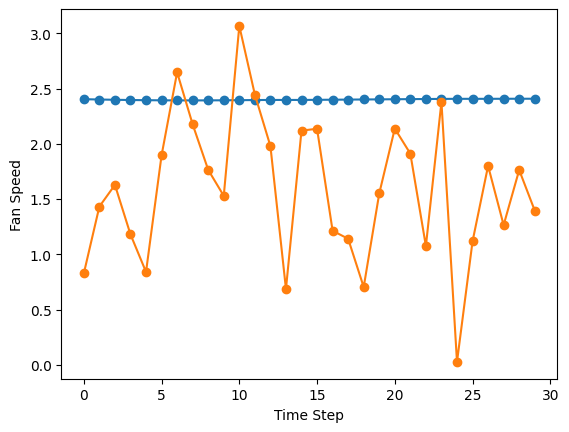

In [50]:
sample = 95
original_fan_speeds = results_mopso[sample + 1]["original_fan_speeds"]
optimized_fan_speeds = results_mopso[sample + 1]["optimal_fan_speeds"]


# sum of squares of the difference between successive fan speeds
fluctuation_score_original = sum((original_fan_speeds[i][0] - original_fan_speeds[i-1][0])**2 for i in range(1, len(original_fan_speeds)))
fluctuation_score_optimized = sum((optimized_fan_speeds[i] - optimized_fan_speeds[i-1])**2 for i in range(1, len(optimized_fan_speeds)))

print(f"Fluctuation Score (Original): {fluctuation_score_original:.4f}")
print(f"Fluctuation Score (Optimized): {fluctuation_score_optimized:.4f}")

plt.plot(original_fan_speeds, label="Original Fan Speeds", marker='o')
plt.plot(optimized_fan_speeds, label="Optimized Fan Speeds", marker='o')
plt.xlabel("Time Step")
plt.ylabel("Fan Speed")
plt.show()


## Change the way fluctuation score is being calculated, start from v_t instead of v_t+1

In [25]:
test_sample = 50
sample_data = results_mopso[test_sample]["pareto_front"]

# Extract objective values from the Pareto front
fan_powers = [obj["objectives"][0] for obj in sample_data]
leakage_powers = [obj["objectives"][1] for obj in sample_data]
penalty_terms = [obj["objectives"][2] for obj in sample_data]

pio.renderers.default = "svg"

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=fan_powers,
    y=leakage_powers,
    z=penalty_terms,
    mode='markers',
    marker=dict(
        size=6,
        colorscale='Viridis',
        opacity=0.8
    ),
    text=[f"Fan Speeds: {[round(fs, 2) for fs in obj['fan_speeds']]}" for obj in sample_data]
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Fan Power',
        yaxis_title='Leakage Power',
        zaxis_title='Smoothness Penalty',
    ),
    title=f"Pareto Front for Sample {test_sample}",
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.write_html(f"pareto_front_sample_mopso_{test_sample}.html")

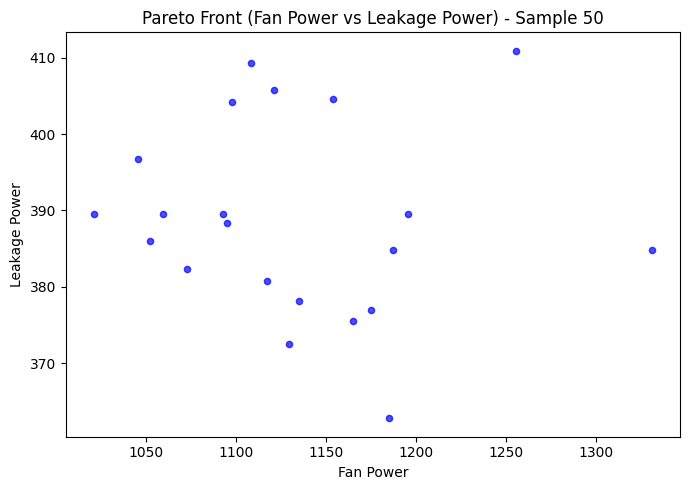

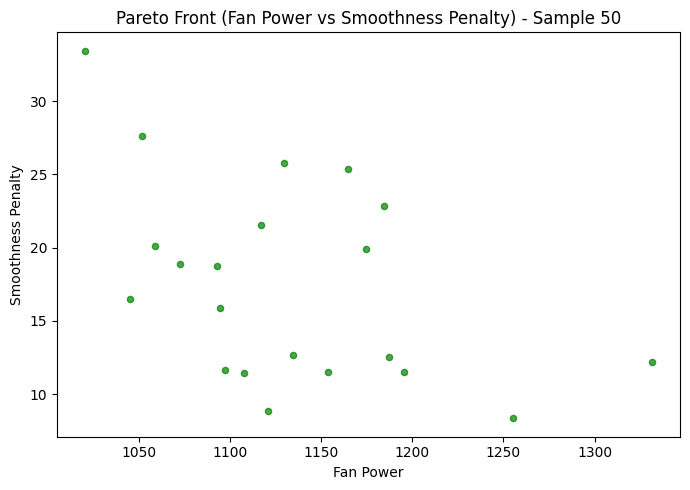

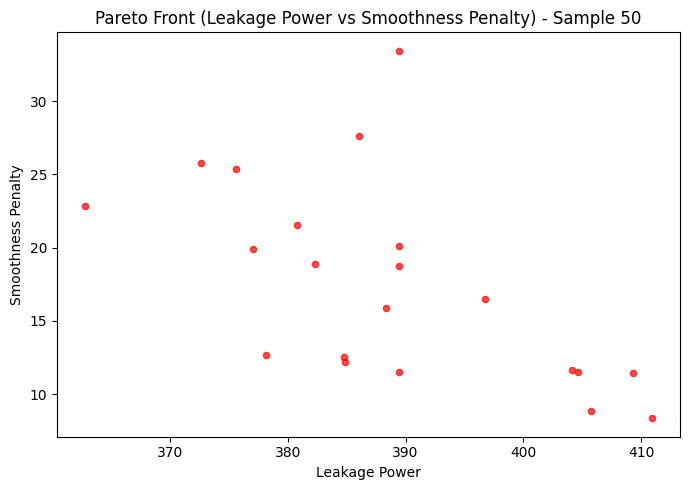

In [26]:
test_sample = 50
sample_data = results_mopso[test_sample]["pareto_front"]

# Extract objective values
fan_powers = [obj["objectives"][0] for obj in sample_data]
leakage_powers = [obj["objectives"][1] for obj in sample_data]
penalty_terms = [obj["objectives"][2] for obj in sample_data]

# 2D Pareto plot 1: Fan Power vs Leakage Power
plt.figure(figsize=(7, 5))
plt.scatter(fan_powers, leakage_powers, c='blue', s=20, alpha=0.7)
plt.xlabel('Fan Power')
plt.ylabel('Leakage Power')
plt.title(f'Pareto Front (Fan Power vs Leakage Power) - Sample {test_sample}')
# plt.grid(True)
plt.tight_layout()
plt.show()

# 2D Pareto plot 2: Fan Power vs Smoothness Penalty
plt.figure(figsize=(7, 5))
plt.scatter(fan_powers, penalty_terms, c='green', s=20, alpha=0.7)
plt.xlabel('Fan Power')
plt.ylabel('Smoothness Penalty')
plt.title(f'Pareto Front (Fan Power vs Smoothness Penalty) - Sample {test_sample}')
# plt.grid(True)
plt.tight_layout()
plt.show()

# 2D Pareto plot 3: Leakage Power vs Smoothness Penalty
plt.figure(figsize=(7, 5))
plt.scatter(leakage_powers, penalty_terms, c='red', s=20, alpha=0.7)
plt.xlabel('Leakage Power')
plt.ylabel('Smoothness Penalty')
plt.title(f'Pareto Front (Leakage Power vs Smoothness Penalty) - Sample {test_sample}')
# plt.grid(True)
plt.tight_layout()
plt.show()


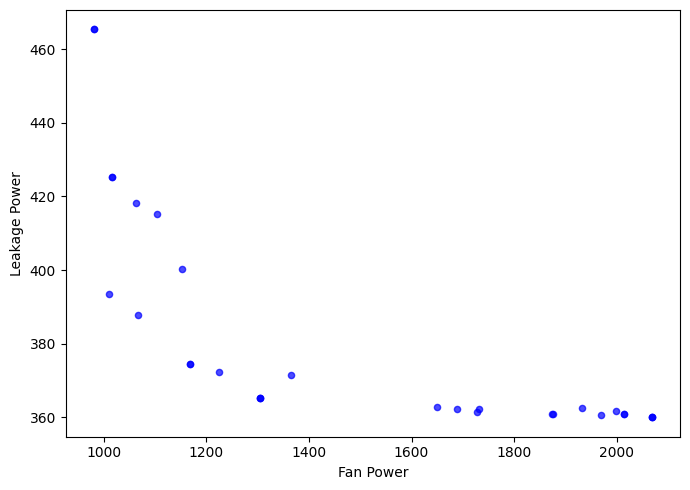

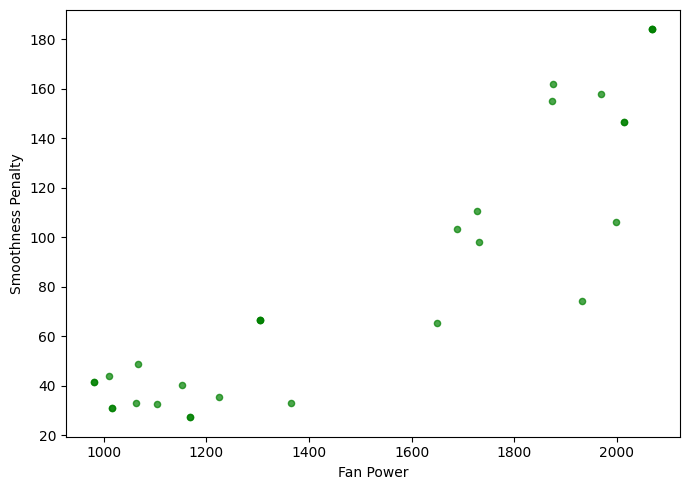

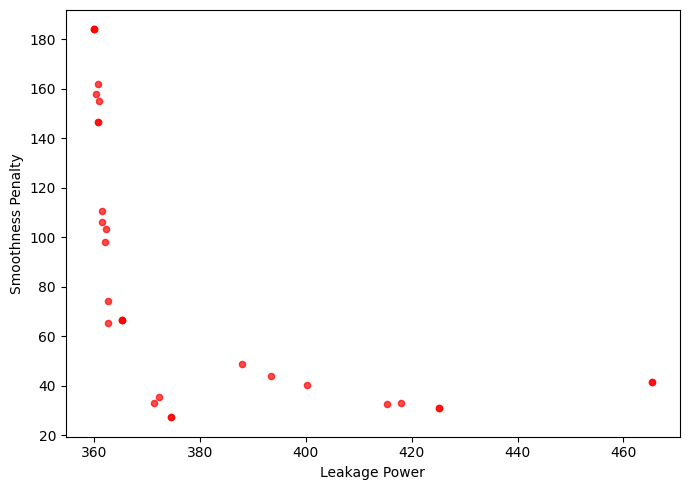

In [ ]:
test_sample = 50
sample_data = results[test_sample]["pareto_front"]

# Extract objective values
fan_powers = [obj["objectives"][0] for obj in sample_data]
leakage_powers = [obj["objectives"][1] for obj in sample_data]
penalty_terms = [obj["objectives"][2] for obj in sample_data]

# 2D Pareto plot 1: Fan Power vs Leakage Power
plt.figure(figsize=(7, 5))
plt.scatter(fan_powers, leakage_powers, c='blue', s=20, alpha=0.7)
plt.xlabel('Fan Power')
plt.ylabel('Leakage Power')
# plt.title(f'Pareto Front (Fan Power vs Leakage Power) - Sample {test_sample}')
# plt.grid(True)
plt.tight_layout()
plt.show()

# 2D Pareto plot 2: Fan Power vs Smoothness Penalty
plt.figure(figsize=(7, 5))
plt.scatter(fan_powers, penalty_terms, c='green', s=20, alpha=0.7)
plt.xlabel('Fan Power')
plt.ylabel('Smoothness Penalty')
# plt.title(f'Pareto Front (Fan Power vs Smoothness Penalty) - Sample {test_sample}')
# plt.grid(True)
plt.tight_layout()
plt.show()

# 2D Pareto plot 3: Leakage Power vs Smoothness Penalty
plt.figure(figsize=(7, 5))
plt.scatter(leakage_powers, penalty_terms, c='red', s=20, alpha=0.7)
plt.xlabel('Leakage Power')
plt.ylabel('Smoothness Penalty')
# plt.title(f'Pareto Front (Leakage Power vs Smoothness Penalty) - Sample {test_sample}')
# plt.grid(True)
plt.tight_layout()
plt.show()
